# Sampling

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle
import gentrl
from moses.utils import CharVocab

import susi
from susi.SOMPlots import plot_estimation_map, plot_som_histogram, plot_umatrix
import torch
from rdkit.Chem import Draw
if torch.cuda.is_available():
  torch.cuda.set_device(0)

! mkdir sampling

In [ ]:
dataset_path = "./data/moses_qed_props.csv.gz"
df = pd.read_csv(dataset_path, compression="gzip")
vocab = CharVocab.from_data(df['SMILES'])

In [ ]:
check_point_sample = "-checkpoint_50000" # "-checkpoint_{num}"
torch.cuda.set_device(0)
enc = gentrl.RNNEncoder(vocab, latent_size=50)
dec = gentrl.DilConvDecoder(vocab, latent_input_size=50, split_len=100)
model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

In [ ]:
##VAE
if check_point_sample != '':
  model.load('saved_model_checkpoint/', version=check_point_sample)
else:
  model.load('saved_model/')
model.cuda();

In [ ]:
##RL
if check_point_sample != '':
  model.load('model_rl_checkpoint/', version=check_point_sample)
else:
  model.load('model_rl/')
model.cuda();

In [ ]:
som_general = pickle.load(open("./SOMs/general_som_1M.p", "rb"))
som_specific = pickle.load(open("./SOMs/specific_som_800K.p", "rb"))

#disable log
som_general.verbose=0
som_general.tqdm_params_={"disable": True}
som_specific.verbose=0
som_specific.tqdm_params_={"disable": True}

In [13]:
from moses.metrics import mol_passes_filters, SA, logP
from moses.metrics.utils import get_n_rings, get_mol

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])


def reward_func(mol_or_smiles, masked=False, show_detail=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    smiles_tokenized = gentrl.tokenizer.encode([mol_or_smiles], vocab)[0][0].tolist()
    logP_award= 5 - (0.8 * abs(logP(mol)-3.5))
    SA_award = -SA(mol)
    rings_award = -get_num_rings_6(mol)
    general_award = 0.24*som_general.predict([smiles_tokenized])[0]
    specific_award = 0.94*som_specific.predict([smiles_tokenized])[0]
    reward = logP_award + SA_award + rings_award + specific_award + general_award
    msg = "%.1f %.1f %.1f %.1f %.1f [%.1f]" % (logP_award, SA_award, rings_award, general_award, specific_award, reward)
    if show_detail:
        return msg
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
generated = []
sampled_valid = []
while len(generated) < 100000:
    sampled = model.sample(1000)
    sampled_valid = [s for s in sampled if get_mol(s)]
    generated += sampled_valid
    print(f"Generated: {len(generated)}")

generated = list(set(generated))

In [ ]:
with open("./sampling/rl_sampled_100k.csv", "w") as f:
    f.writelines("%s\n" % sm for sm in generated)

In [ ]:
df = pd.DataFrame(generated, columns=['smiles'])
df['reward'] = df['smiles'].apply(lambda x: reward_func(x))
df.sort_values("reward",inplace=True, ascending=False)
df.to_csv("./sampling/rl_sampled_100k_sorted.csv", index=None)

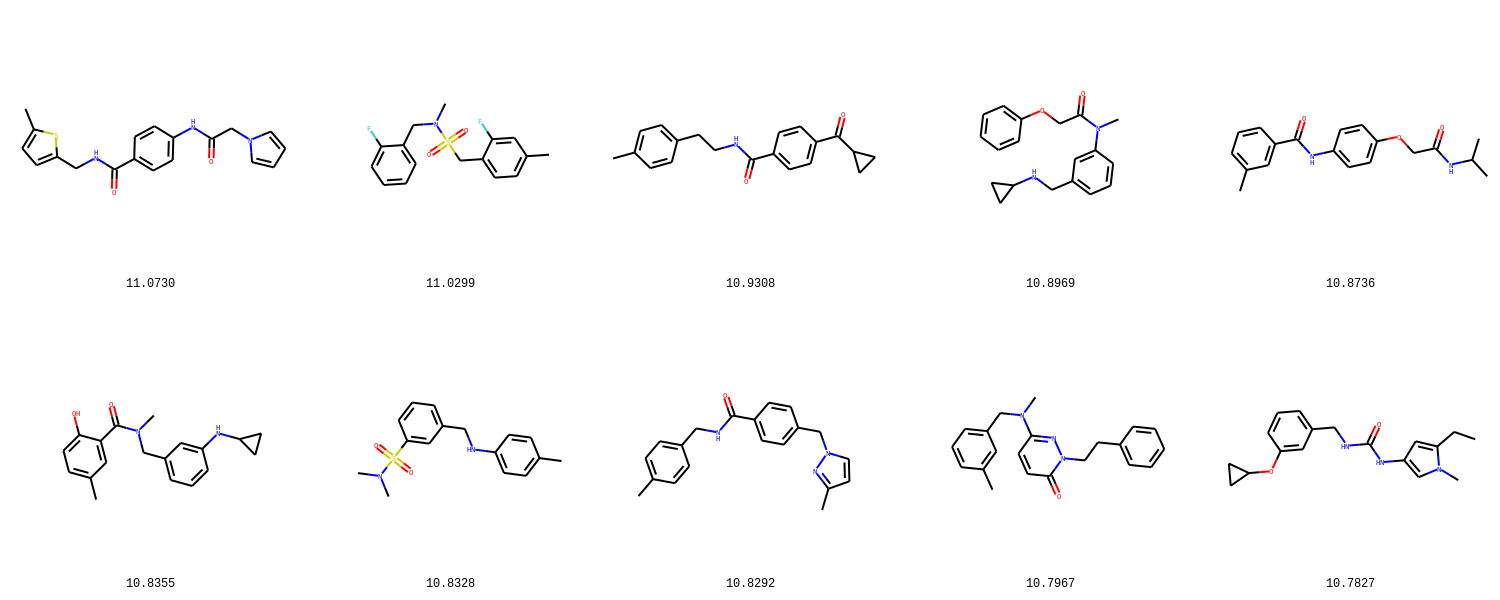

<Figure size 3000x3000 with 0 Axes>

In [ ]:
Draw.MolsToGridImage([get_mol(s) for s in generated_sorted[:10]], molsPerRow=5, subImgSize=(300,300),
                     #useSVG=True,
                     legends=[str(format(reward_func(s), '.4f')) for s in generated_sorted[:10]])
                     #legends=[str(reward_func(s,show_detail=True)) for s in generated_sorted[:10]])

## Sampling Pretrain Model

In [ ]:
generated = []
sampled_valid = []
while len(generated) < 100000:
    sampled = model.sample(1000)
    sampled_valid = [s for s in sampled if get_mol(s)]
    generated += sampled_valid
    print(f"Generated: {len(generated)}")
generated = list(set(generated))
with open(f"./sampling/pretrain_sampled_100k.csv", "w") as f:
    f.writelines("%s\n" % sm for sm in generated)

Generated: 125
Generated: 278
Generated: 421
Generated: 570
Generated: 711
Generated: 823
Generated: 958
Generated: 1096
Generated: 1223
Generated: 1373
Generated: 1514
Generated: 1640
Generated: 1759
Generated: 1886
Generated: 2011
Generated: 2142
Generated: 2282
Generated: 2406
Generated: 2525
Generated: 2663
Generated: 2806
Generated: 2926
Generated: 3051
Generated: 3181
Generated: 3324
Generated: 3454
Generated: 3577
Generated: 3708
Generated: 3826
Generated: 3965
Generated: 4096
Generated: 4249
Generated: 4382
Generated: 4504
Generated: 4626
Generated: 4743
Generated: 4878
Generated: 4998
Generated: 5130
Generated: 5246
Generated: 5356
Generated: 5468
Generated: 5601
Generated: 5722
Generated: 5856
Generated: 6002
Generated: 6127
Generated: 6251
Generated: 6384
Generated: 6503
Generated: 6629
Generated: 6761
Generated: 6883
Generated: 7037
Generated: 7151
Generated: 7283
Generated: 7393
Generated: 7521
Generated: 7650
Generated: 7773
Generated: 7891
Generated: 8014
Generated: 8149

## Sampling RL Model

In [ ]:
for i in range(1,11):
  generated = []
  sampled_valid = []
  while len(generated) < 30000:
      sampled = model.sample(1000)
      sampled_valid = [s for s in sampled if get_mol(s)]
      generated += sampled_valid
  generated = list(set(generated))
  print(f"Generated 30000 * {i}")
  with open(f"./sampling/rl_sampled_{i}.csv", "w") as f:
    f.writelines("%s\n" % sm for sm in generated)

Generated 30000 * 1
Generated 30000 * 2
Generated 30000 * 3
Generated 30000 * 4
Generated 30000 * 5
Generated 30000 * 6
Generated 30000 * 7
Generated 30000 * 8
Generated 30000 * 9
Generated 30000 * 10


# Figure generate

In [10]:
df = pd.read_csv("./sampling/rl_sampled_100k_sorted.csv")
generated_sorted = df["smiles"].tolist()

In [11]:
! mkdir figure

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = False

In [18]:
for i in range(100):
  Draw.MolToFile(get_mol(generated_sorted[i]),f"./figure/{i+1}.png",size=(500,150))

In [19]:
! tar -zcvf figure.tar.gz figure

figure/
figure/91.png
figure/52.png
figure/41.png
figure/92.png
figure/61.png
figure/79.png
figure/31.png
figure/16.png
figure/30.png
figure/81.png
figure/11.png
figure/29.png
figure/78.png
figure/93.png
figure/75.png
figure/46.png
figure/71.png
figure/73.png
figure/22.png
figure/90.png
figure/55.png
figure/86.png
figure/17.png
figure/62.png
figure/63.png
figure/27.png
figure/26.png
figure/97.png
figure/48.png
figure/72.png
figure/51.png
figure/34.png
figure/.ipynb_checkpoints/
figure/49.png
figure/69.png
figure/19.png
figure/100.png
figure/12.png
figure/56.png
figure/58.png
figure/95.png
figure/80.png
figure/28.png
figure/9.png
figure/43.png
figure/98.png
figure/54.png
figure/85.png
figure/7.png
figure/4.png
figure/33.png
figure/1.png
figure/15.png
figure/3.png
figure/38.png
figure/67.png
figure/8.png
figure/82.png
figure/70.png
figure/14.png
figure/25.png
figure/35.png
figure/84.png
figure/23.png
figure/83.png
figure/10.png
figure/94.png
figure/77.png
figure/2.png
figure/47.png
figur